# Spare-it DS701 Project

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Client Overview and Problem Statement

## 1.1 About Spare-it


> **Spare-it: Pioneering Sustainable Waste Management with Cutting-Edge Technology**
- Spare-it is a leading sustainable waste management company, harnessing technology and environmental stewardship to help businesses, universities, and office owners reduce their environmental impact, save costs, and enhance efficiency. Its core strategy involves a robust technological framework, combining advanced hardware and software, strategic office design, and gamification to develop comprehensive waste management programs. These initiatives not only boost recycling but also aim to significantly cut waste production.
- The company’s mission centers on being a sustainability catalyst, driven by the belief that environmental awareness and behavior change require solid data intelligence. Spare-it provides real-time data on various waste management aspects, including general waste, recycling, and resource utilization like energy and water. This approach empowers organizations to make informed decisions and adopt effective waste reduction strategies.
- Spare-it's innovative approach, particularly through gamification, fosters a culture of environmental responsibility among employees and students, making waste management an engaging and meaningful endeavor. Ultimately, Spare-it positions itself as more than a waste management company; it's a collaborative partner in shaping a sustainable future, one step at a time.

## 1.2 Problem Statement

### **Task 1 :** Comparative Analysis of Manual (Fullness) Versus Scale Weight Measurements

> **Overview:** This detailed comparative analysis aims to meticulously examine the differences between manual weight measurements conducted by students and the measurements obtained from scales, as recorded in our dataset. The objective is to identify and analyze any notable discrepancies between these two methods. Additionally, this analysis will explore the potential causes of these variances, providing insights into the reliability and accuracy of manual versus scale measurements. This investigation is crucial for understanding the effectiveness of manual weight estimation techniques and the precision of scale measurements, ultimately contributing to the enhancement of data collection methods in weight measurement studies.

### **Task 2:** Noise and Signal Ratio Analysis for Scales

# 2. EDA

## 2.1 Data Overview

> We have two datasets:
- scale_records: This dataset comprises automated scale measurements of waste bins. It includes the weight data along with error codes and other metadata
- fullness_assessments: This dataset represents manual assessments of waste bin fullness. Each record includes details about the bin, its location, and the assessment specifics

In [4]:
fullness_assessments = pd.read_csv("/Users/ishan/Downloads/fullness-assessments CCDS as of Oct 13 2023.csv")
scale_records = pd.read_csv("/Users/ishan/Downloads/Spare-it V5 scale records Jan 1 to Oct 16 2023-001.csv")

## 2.2 Data Cleaning

### 2.2.1 Missing Values

In [5]:
print(fullness_assessments.isna().sum())
print(scale_records.isna().sum())

bin            0
date           0
account        0
building       0
floor          0
stationName    0
binName        0
category       0
fullness       0
dtype: int64
createdat            0
iotid                0
hide                 0
bin                  0
errorcode            0
weight               0
battery              0
updatedat            0
weightdiff    26979124
year                 0
month                0
day                  0
dtype: int64


### 2.2.2 Duplicate records

In [7]:
duplicates = scale_records[scale_records.duplicated()]
duplicates.shape # 11.6M Duplicates

(11684870, 12)

In [8]:
scale_records_clean = scale_records.drop_duplicates()

# 3. Comparative analysis of manual fullness and scale weight measurements

## 4. Bin weight anomaly detection

## 4.1 Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
from copy import deepcopy

In [7]:
v5 = pd.read_csv("/Users/charliechou/Downloads/Spare-it V5 scale records Jan 1 to Oct 16 2023-001.csv")

In [ ]:
# Drop duplicates
v5.drop_duplicates(inplace=True) 

# Change the type of ‘createdat’ to datetime and create a new column of ‘createdat_ns’
v5['createdat_ns'] = pd.to_datetime(v5["createdat"])

# Drop the rows where the ‘hide’ value is True
v5.drop(v5[v5.hide].index, axis=0, inplace=True)

# Drop unnecessary columns
v5.drop(['createdat','updatedat','year','month','day','errorcode',"hide","weightdiff","battery"], axis=1, inplace=True)

# Group by "bin" and sort by "createdat_ns"
v5 = v5.groupby(by='bin').apply(lambda x: x.sort_values(["createdat_ns"],ascending= True))

# Reset index
v5.reset_index(drop=True,inplace=True)

# Caculate time interval
v5['interval'] = np.nan
same_bin = v5.bin == v5.bin.shift(1)
v5.interval = v5.createdat_ns[same_bin] - v5.createdat_ns.shift(1)[same_bin]

v5.head()

,iotid,bin,weight,createdat_ns,interval
0,lora-001784,002a3bdd-18b3-459f-9377-483249ccf9b6,4588.387884,2023-09-22 17:02:00,NaT
1,lora-001784,002a3bdd-18b3-459f-9377-483249ccf9b6,4588.387884,2023-09-22 17:08:00,0 days 00:06:00
2,lora-001784,002a3bdd-18b3-459f-9377-483249ccf9b6,4585.336080,2023-09-22 17:13:00,0 days 00:05:00
3,lora-001784,002a3bdd-18b3-459f-9377-483249ccf9b6,4588.387884,2023-09-22 17:18:00,0 days 00:05:00
4,lora-001784,002a3bdd-18b3-459f-9377-483249ccf9b6,4585.336080,2023-09-22 17:23:00,0 days 00:05:00


## 4.2 Data Exploration

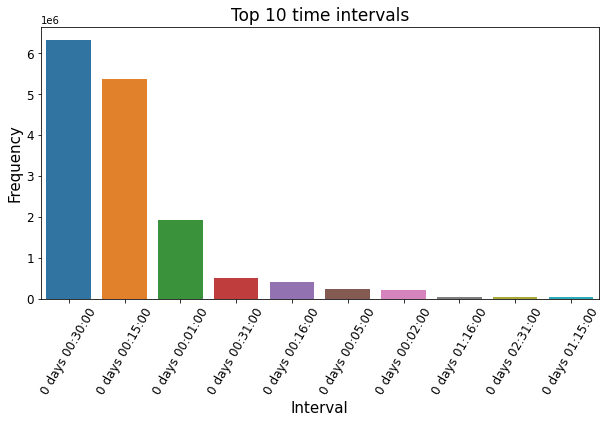

In [ ]:
# Plot the bar chart of the top 10 intervals
interval_counts = v5['interval'].value_counts()
top_intervals = interval_counts.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_intervals.index, y=top_intervals.values)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Interval', fontsize=15)
plt.xticks(fontsize=12, rotation=60)
plt.yticks(fontsize=12)
plt.title("Top 10 time intervals",fontsize=17)
plt.show()

# 30-minute intervals have the highest number of occurrences

In [ ]:
# Create a dictionary to find the relationship between iotid, bin and the number of records
iotid_bin = defaultdict(lambda: defaultdict(int))

for j in tqdm(range(len(v5))):
    iotid_bin[v5.iotid[j]][v5.bin[j]]+=1
    
iotid_bin

# One scale can be used to weigh different bins and one bin can be weighed by different scales.

100%|██████████| 15182180/15182180 [05:27<00:00, 46344.49it/s] 


defaultdict(<function __main__.<lambda>()>,
            {'lora-001784': defaultdict(int,
                         {'002a3bdd-18b3-459f-9377-483249ccf9b6': 1137,
                          '40bc2b26-77ef-4bcc-a2b3-ac8628f67d6c': 6329}),
             'lora-000740': defaultdict(int,
                         {'002e9840-2213-4870-8fe9-7f81f7f23726': 23727,
                          'a7e31415-adee-48ed-8417-8a0a8fc2cc15': 60}),
             'lora-000350': defaultdict(int,
                         {'007099f0-9c71-45d7-a3d0-2f44f83f7f40': 12965}),
             'lora-000131': defaultdict(int,
                         {'00758e5d-6d04-4b4a-b4d8-a203672d8263': 489,
                          '77780108-32f4-4a05-bc91-25ffa067e3d4': 6658,
                          'e64475a1-7788-4745-954f-171b178e7184': 3987}),
             'lora-000241': defaultdict(int,
                         {'00758e5d-6d04-4b4a-b4d8-a203672d8263': 24783,
                          '01d059d1-87b7-4bbb-abc8-072f795465a9': 173}),
  

In [ ]:
# Create a dictionary whose keys are the IDs of scales that weigh multiple bins and whose values are the IDs of the bins
iotid_special = {}
for k, v in iotid_bin.items():
    if len(v)>1:
        iotid_special[k]=list(v.keys())

len(iotid_special)
#There are 172 scales used to weigh more than one bin.

172

## 4.3 Moving Average Method

In [ ]:
v5_1 = deepcopy(v5)

v5_1.index = v5_1.createdat_ns

#Compute moving averages for each bin
v5_1['rolling_weight'] = v5_1.groupby('bin')['weight'].transform(lambda x: x.rolling('2h', min_periods=1).mean())
v5_1['std_dev'] = v5_1.groupby('bin')['rolling_weight'].transform('std')

v5_1.reset_index(drop=True,inplace=True)

#Create confidence bands for anomalies using rolling_weight
v5_1['upper_bound'] = v5_1['rolling_weight'] + 2 * v5_1['std_dev']
v5_1['lower_bound'] = v5_1['rolling_weight'] - 2 * v5_1['std_dev']

v5_1['anomaly_flag'] = (v5_1['weight'] > v5_1['upper_bound']) | (v5_1['weight'] < v5_1['lower_bound'])

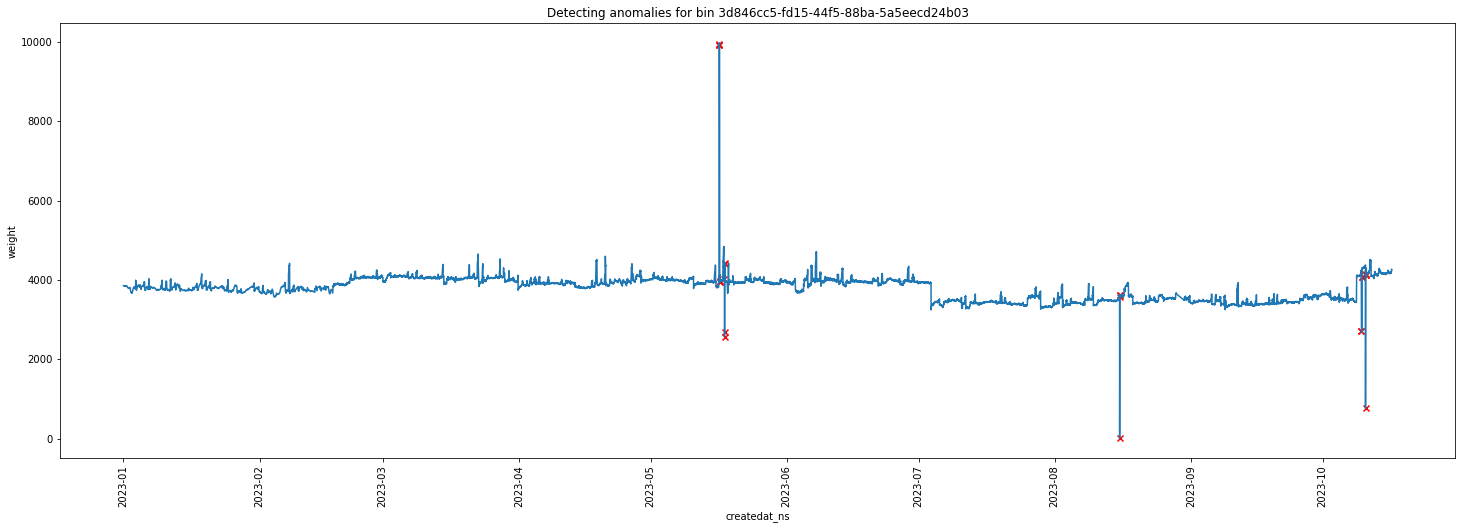

In [ ]:
#Anomalies plot
plt.figure(figsize=(25,8))

anomaly_points = v5_1[(v5_1['bin'] == '3d846cc5-fd15-44f5-88ba-5a5eecd24b03') & v5_1['anomaly_flag']]

sns.lineplot(data=v5_1[v5_1['bin']=='3d846cc5-fd15-44f5-88ba-5a5eecd24b03'],x='createdat_ns',y='weight')
plt.scatter(anomaly_points['createdat_ns'], anomaly_points['weight'], marker='x', color='red', label='Anomaly')
plt.title('Detecting anomalies for bin 3d846cc5-fd15-44f5-88ba-5a5eecd24b03')
plt.xticks(rotation=90)
plt.show()

## 4.4 ARIMA Method

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

#Check ADF score for specific bins (Apply differencing if bin not stationary)

bin1= v5[v5['bin']=='3d846cc5-fd15-44f5-88ba-5a5eecd24b03'].set_index('createdat_ns')

test_result = adfuller(bin1['weight'])
print(f'ADF  {test_result[0]}')
print(f'p-value : {test_result[1]}')

ADF  -3.660123868516457
p-value : 0.004710321609259378


d:\program\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


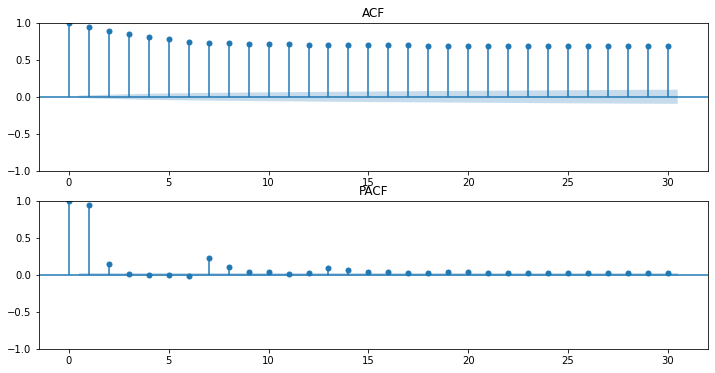

In [ ]:
# Subset data for the specified bin
bin_id = '3d846cc5-fd15-44f5-88ba-5a5eecd24b03'

subset = v5[v5['bin'] == bin_id]
series = subset['weight']

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(series, lags=30, ax=plt.gca(), title='ACF')

plt.subplot(2, 1, 2)
plot_pacf(series, lags=30, ax=plt.gca(), title='PACF')

plt.show()

In [ ]:
# Fit ARIMA model
order = (1, 0, 5)  #Adjust order for different bins
model = ARIMA(subset['weight'], order=order)
fit_model = model.fit()

# Get predictions and residuals
subset['predicted_weight'] = fit_model.predict(start=subset.index.min(), end=subset.index.max(), dynamic=False)
subset['residuals'] = subset['weight'] - subset['predicted_weight']
residual_mean = np.mean(subset['residuals'])


# Set a threshold for anomaly detection 
threshold = residual_mean+2.0 * subset['residuals'].std()

# Identify anomalies based on residuals
subset['anomaly_flag'] = (np.abs(subset['residuals']) > threshold).astype(int)

d:\program\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\program\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\program\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\program\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\15292\AppData\Local\Temp\ipykernel_25204\1234491031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

<AxesSubplot:xlabel='createdat_ns', ylabel='weight'>

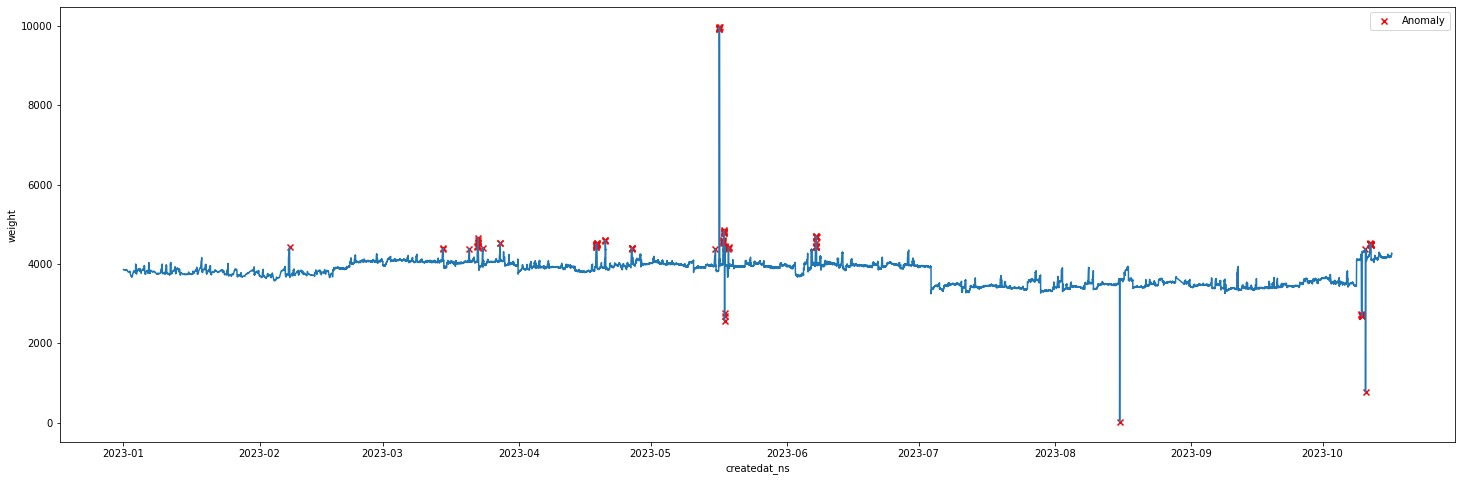

In [ ]:
#Anomalies plot
plt.figure(figsize=(25,8))
anomaly_points = subset[(subset['bin'] == '3d846cc5-fd15-44f5-88ba-5a5eecd24b03') & subset['anomaly_flag']]
plt.scatter(anomaly_points['createdat_ns'], anomaly_points['weight'], marker='x', color='red', label='Anomaly')
sns.lineplot(data=subset,x='createdat_ns',y='weight')

## 4.5 PCA Method

### 4.5.1 Analysis of Data over a One-Month Time Period

In [ ]:
v5_3 = deepcopy(v5)

# Select the records for January 2023
v5_jan = v5_3.loc[(v5_3.createdat_ns<'2023-02-01 00:00:00') & (v5_3.createdat_ns>='2023-01-01 00:00:00')]

v5_jan.reset_index(drop=True,inplace=True)

print(f"In January 2023, there were {len(v5_jan)} records for {len(v5_jan.bin.unique())} bins.")

In January 2023, there were 1137556 records for 698 bins.


To avoid errors caused by filling NaN, we dropped the bins that have few records.

In [ ]:
# Get unique bin IDs and their corresponding counts
bin_id, count = np.unique(v5_jan.bin, return_counts=True)

# Set the threshold for the minimum number of records
n = 2000

# Identify the bins with less than n records
bin_d = bin_id[count<n]
bin_d_ind = v5_jan[v5_jan['bin'].isin(bin_d)].index 

# Drop the bins that have less than n records.
v5_jan.drop(bin_d_ind, axis=0, inplace=True)
v5_jan.reset_index(drop=True,inplace=True)

print(f"There are {len(bin_d)} bins with less than {n} records.")
print(f"These {len(bin_d)} bins have a total of {len(bin_d_ind)} records.")

There are 562 bins with less than 2000 records.
These 562 bins have a total of 583595 records.


C:\Users\15292\AppData\Local\Temp\ipykernel_25204\348347508.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v5_jan.drop(bin_d_ind, axis=0, inplace=True)


Create a dataframe where the index represents the bin IDs and each column represents a timestamp in January 2023. 
The values in the dataframe represent the bin weights at each time point. 
If no record is available for a bin at a specific time, the corresponding cell will have NaN as the value.

In [ ]:
# Get unique time and bin values
bin = v5_jan.bin.unique()
time = sorted(set(v5_jan['createdat_ns']))

# Create a defaultdict to store bin weights for each time point
bin_time = defaultdict(lambda: defaultdict(list))

# Initialize bin_time dictionary with NaN values
for i in bin:
    for j in time:
        bin_time[i][j] = float('nan')

# Fill in bin weights
for i in range(len(v5_jan)):
    bin_time[v5_jan.bin[i]][v5_jan.createdat_ns[i]] = v5_jan.weight[i]

# Convert the bin_time dictionary to a DataFrame, with bin IDs as the index
df = pd.DataFrame.from_dict(bin_time, orient='index')

df.head()

,2023-01-01 00:01:00,2023-01-01 00:02:00,2023-01-01 00:03:00,2023-01-01 00:04:00,2023-01-01 00:05:00,2023-01-01 00:06:00,2023-01-01 00:07:00,2023-01-01 00:08:00,2023-01-01 00:09:00,2023-01-01 00:10:00,...,2023-01-31 23:50:00,2023-01-31 23:51:00,2023-01-31 23:52:00,2023-01-31 23:53:00,2023-01-31 23:54:00,2023-01-31 23:55:00,2023-01-31 23:56:00,2023-01-31 23:57:00,2023-01-31 23:58:00,2023-01-31 23:59:00
00758e5d-6d04-4b4a-b4d8-a203672d8263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
038e82af-4905-49c2-9100-674dd1f9c31a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05569e6c-a11a-4dab-906e-37955e7e9808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1921.110857,NaN,NaN
07fad9d5-a3e3-4a90-a518-b9636db99444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5000.381476,NaN,NaN,NaN,NaN
0853f3e5-5a9e-4171-b8da-78e460255366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1149.004349,NaN,NaN,NaN


In [ ]:
# Fill the NaN values
df_fill = df.interpolate(method='linear',axis=1)
df_fill = df_fill.fillna(method='bfill',axis=1)
df_fill.head()

,2023-01-01 00:01:00,2023-01-01 00:02:00,2023-01-01 00:03:00,2023-01-01 00:04:00,2023-01-01 00:05:00,2023-01-01 00:06:00,2023-01-01 00:07:00,2023-01-01 00:08:00,2023-01-01 00:09:00,2023-01-01 00:10:00,...,2023-01-31 23:50:00,2023-01-31 23:51:00,2023-01-31 23:52:00,2023-01-31 23:53:00,2023-01-31 23:54:00,2023-01-31 23:55:00,2023-01-31 23:56:00,2023-01-31 23:57:00,2023-01-31 23:58:00,2023-01-31 23:59:00
00758e5d-6d04-4b4a-b4d8-a203672d8263,9208.819715,9208.819715,9208.819715,9208.819715,9208.819715,9208.819715,9208.819715,9208.819715,9208.819715,9208.819715,...,35.095750,35.095750,35.095750,35.095750,35.095750,35.095750,35.095750,35.095750,35.095750,35.095750
038e82af-4905-49c2-9100-674dd1f9c31a,111.390860,111.390860,111.390860,111.390860,111.390860,111.390860,111.390860,111.390860,111.390860,111.390860,...,-251.773861,-251.773861,-251.773861,-251.773861,-251.773861,-251.773861,-251.773861,-251.773861,-251.773861,-251.773861
05569e6c-a11a-4dab-906e-37955e7e9808,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,...,1913.989980,1915.007248,1916.024516,1917.041784,1918.059052,1919.076321,1920.093589,1921.110857,1921.110857,1921.110857
07fad9d5-a3e3-4a90-a518-b9636db99444,90.028229,90.028229,90.028229,90.028229,90.028229,90.028229,90.028229,90.028229,90.028229,90.028229,...,5000.381476,5000.381476,5000.381476,5000.381476,5000.381476,5000.381476,5000.381476,5000.381476,5000.381476,5000.381476
0853f3e5-5a9e-4171-b8da-78e460255366,2217.135882,2217.135882,2217.135882,2217.135882,2217.135882,2217.135882,2217.135882,2217.135882,2217.135882,2217.135882,...,1147.783627,1147.987081,1148.190534,1148.393988,1148.597442,1148.800895,1149.004349,1149.004349,1149.004349,1149.004349


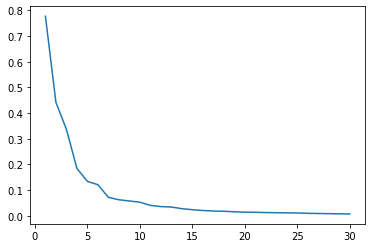

In [ ]:
# Convert dataframe to numpy array
df_fill_v = df_fill.values

# Calculate norm of each bin
norm = np.linalg.norm(df_fill_v, axis=1, ord=1)

# Perform SVD
u,s,vt = np.linalg.svd(df_fill_v ,full_matrices=False)

# Plot the normalized singular values
plt.plot(range(1, 31), s[0:30]/np.linalg.norm(df_fill_v))


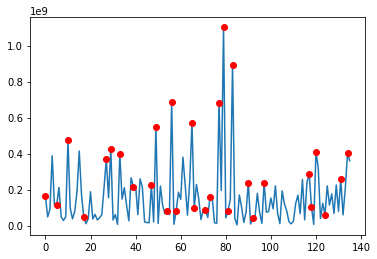

In [ ]:
# choose the top 10 columns of U for the normal space
unorm = u[:,0:9]
P = unorm.dot(unorm.T)
N = P.dot(df_fill)
O = df_fill - N
Onorm = np.linalg.norm(O,axis=1)
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(norm)
plt.plot(anomSet,norm[anomSet],'ro')

Text(0.5, 0.98, 'Nine Example Anomalous Bins')

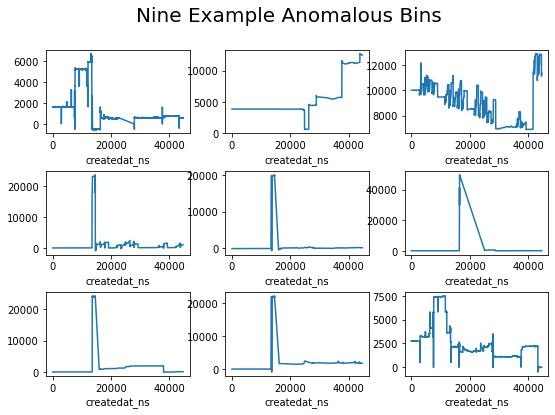

In [ ]:
#sample anomalous
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(df_fill_v[anomSet[i-1],:])
    plt.xlabel('createdat_ns')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Bins',size=20)

Text(0.5, 0.98, 'Nine Example Normal Bins')

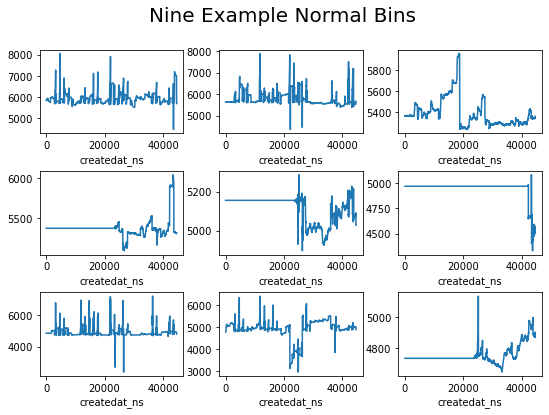

In [ ]:
# choose non-anomalous bins
set = np.argsort(Onorm)[0:70]
# that have high overall volume
max = np.argsort(norm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(df_fill_v[set[max[i-1]],:])
    plt.xlabel('createdat_ns')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Bins',size=20)

### 4.5.2 Analysis of Data over a One-Week Time Period

In [ ]:
v5_4 = deepcopy(v5)

# Select the records for January 2023
v5_week = v5_4.loc[(v5_4.createdat_ns<'2023-01-08 00:00:00') & (v5_4.createdat_ns>='2023-01-01 00:00:00')]

v5_week.reset_index(drop=True,inplace=True)

print(f"In the first week of January 2023, there were {len(v5_week)} records for {len(v5_week.bin.unique())} bins.")

In the first week of January 2023, there were 114591 records for 215 bins.


To avoid errors caused by filling NaN, we dropped the bins that have few records.

In [ ]:
# Get unique bin IDs and their corresponding counts
bin_id, count = np.unique(v5_week.bin, return_counts=True)

# Set the threshold for the minimum number of records
n = 300

# Identify the bins with less than n records
bin_d = bin_id[count<n]
bin_d_ind = v5_week[v5_week['bin'].isin(bin_d)].index 

# Drop the bins that have less than n records.
v5_week.drop(bin_d_ind, axis=0, inplace=True)
v5_week.reset_index(drop=True,inplace=True)

print(f"There are {len(bin_d)} bins with less than {n} records.")
print(f"These {len(bin_d)} bins have a total of {len(bin_d_ind)} records.")

There are 31 bins with less than 300 records.
These 31 bins have a total of 8663 records.


C:\Users\15292\AppData\Local\Temp\ipykernel_10680\2530798061.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v5_week.drop(bin_d_ind, axis=0, inplace=True)


Create a dataframe where the index represents the bin IDs and each column represents a timestamp in January 2023. 
The values in the dataframe represent the bin weights at each time point. 
If no record is available for a bin at a specific time, the corresponding cell will have NaN as the value.

In [ ]:
# Get unique time and bin values
bin = v5_week.bin.unique()
time = sorted(set(v5_week['createdat_ns']))

# Create a defaultdict to store bin weights for each time point
bin_time = defaultdict(lambda: defaultdict(list))

# Initialize bin_time dictionary with NaN values
for i in bin:
    for j in time:
        bin_time[i][j] = float('nan')

# Fill in bin weights
for i in range(len(v5_week)):
    bin_time[v5_week.bin[i]][v5_week.createdat_ns[i]] = v5_week.weight[i]

# Convert the bin_time dictionary to a DataFrame, with bin IDs as the index
df = pd.DataFrame.from_dict(bin_time, orient='index')

df.head()

,2023-01-01 00:01:00,2023-01-01 00:02:00,2023-01-01 00:03:00,2023-01-01 00:04:00,2023-01-01 00:05:00,2023-01-01 00:06:00,2023-01-01 00:07:00,2023-01-01 00:08:00,2023-01-01 00:09:00,2023-01-01 00:10:00,...,2023-01-07 23:50:00,2023-01-07 23:51:00,2023-01-07 23:52:00,2023-01-07 23:53:00,2023-01-07 23:54:00,2023-01-07 23:55:00,2023-01-07 23:56:00,2023-01-07 23:57:00,2023-01-07 23:58:00,2023-01-07 23:59:00
0539a4be-8373-48f5-953b-8dd427d7cc96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2455.176623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05569e6c-a11a-4dab-906e-37955e7e9808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05df844c-5f72-4b89-8107-97b2519f6371,NaN,NaN,8720.531014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8720.531014,NaN,NaN,NaN
089d308d-e797-41af-ae64-b7926136e0d2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09b1ece7-5aaa-4c66-a89a-ac6a99bae6ed,2754.253452,2751.201648,2754.253452,2757.305257,2757.305257,2754.253452,2751.201648,2757.305257,2754.253452,2754.253452,...,7417.410544,NaN,7417.410544,7414.35874,7417.410544,7417.410544,7417.410544,7414.35874,7417.410544,7417.410544


In [ ]:
# Fill the NaN values
df_fill = df.interpolate(method='linear',axis=1)
df_fill = df_fill.fillna(method='bfill',axis=1)
df_fill.head()

,2023-01-01 00:01:00,2023-01-01 00:02:00,2023-01-01 00:03:00,2023-01-01 00:04:00,2023-01-01 00:05:00,2023-01-01 00:06:00,2023-01-01 00:07:00,2023-01-01 00:08:00,2023-01-01 00:09:00,2023-01-01 00:10:00,...,2023-01-07 23:50:00,2023-01-07 23:51:00,2023-01-07 23:52:00,2023-01-07 23:53:00,2023-01-07 23:54:00,2023-01-07 23:55:00,2023-01-07 23:56:00,2023-01-07 23:57:00,2023-01-07 23:58:00,2023-01-07 23:59:00
0539a4be-8373-48f5-953b-8dd427d7cc96,2671.854734,2671.854734,2671.854734,2671.854734,2671.854734,2671.854734,2671.854734,2671.854734,2671.854734,2671.854734,...,2455.176623,2455.176623,2455.176623,2455.176623,2455.176623,2455.176623,2455.176623,2455.176623,2455.176623,2455.176623
05569e6c-a11a-4dab-906e-37955e7e9808,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,1884.489204,...,1896.696422,1896.696422,1896.696422,1896.696422,1896.696422,1896.696422,1896.696422,1896.696422,1896.696422,1896.696422
05df844c-5f72-4b89-8107-97b2519f6371,8720.531014,8720.531014,8720.531014,8720.531014,8720.531014,8720.531014,8720.531014,8720.531014,8720.531014,8720.531014,...,8721.141375,8721.039648,8720.937921,8720.836194,8720.734468,8720.632741,8720.531014,8720.531014,8720.531014,8720.531014
089d308d-e797-41af-ae64-b7926136e0d2,3562.981613,3562.981613,3562.981613,3562.981613,3562.981613,3562.981613,3562.981613,3562.981613,3562.981613,3562.981613,...,3596.551461,3596.551461,3596.551461,3596.551461,3596.551461,3596.551461,3596.551461,3596.551461,3596.551461,3596.551461
09b1ece7-5aaa-4c66-a89a-ac6a99bae6ed,2754.253452,2751.201648,2754.253452,2757.305257,2757.305257,2754.253452,2751.201648,2757.305257,2754.253452,2754.253452,...,7417.410544,7417.410544,7417.410544,7414.358740,7417.410544,7417.410544,7417.410544,7414.358740,7417.410544,7417.410544


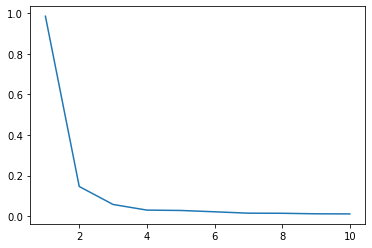

In [ ]:
# Convert dataframe to numpy array
df_fill_v = df_fill.values

# Calculate norm of each bin
norm = np.linalg.norm(df_fill_v, axis=1, ord=1)

# Perform SVD
u,s,vt = np.linalg.svd(df_fill_v ,full_matrices=False)

# Plot the normalized singular values
plt.plot(range(1,11),s[:10]/np.linalg.norm(df_fill_v ))


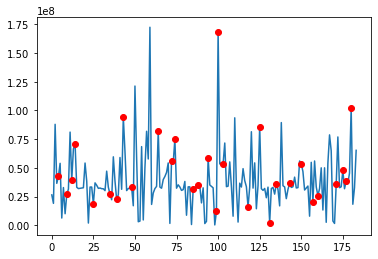

In [ ]:
# choose the top 4 columns of U for the normal space
unorm = u[:,0:3]
P = unorm.dot(unorm.T)
N = P.dot(df_fill)
O = df_fill - N
Onorm = np.linalg.norm(O,axis=1)
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(norm)
plt.plot(anomSet,norm[anomSet],'ro')

Text(0.5, 0.98, 'Nine Example Anomalous Bins')

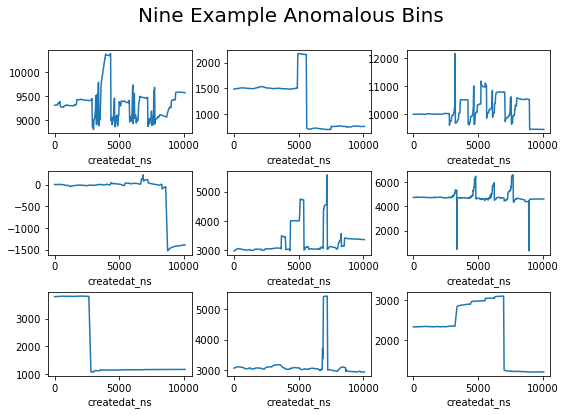

In [ ]:
#sample anomalous
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(df_fill_v[anomSet[i-1],:])
    plt.xlabel('createdat_ns')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Bins',size=20)

Text(0.5, 0.98, 'Nine Example Normal Bins')

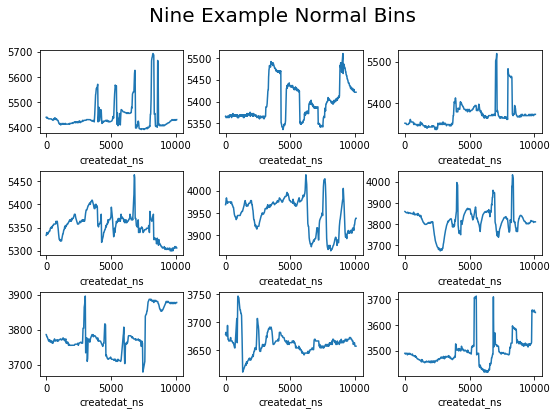

In [ ]:
# choose non-anomalous bins
set = np.argsort(Onorm)[0:80]
# that have high overall volume
max = np.argsort(norm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(df_fill_v[set[max[i-1]],:])
    plt.xlabel('createdat_ns')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Bins',size=20)

# 5. Limitations and Potential Risks